<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-ai-in-controlling/blob/main/lecture_2/2_4_ts_04_forecasting_with_ml_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with machine learning

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Print Keras version
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.3.3


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

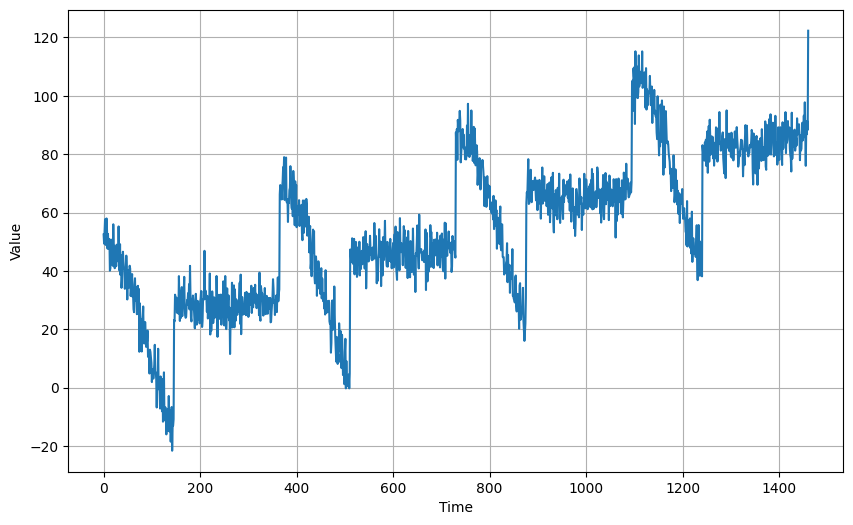

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with a "simple" Deep Learning Method

We choose the simplest Deep Learning Model possible, which consists
of 1 layer and 1 unit. This model is equivalent to linear regression.


First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    """
    Generate a data set in the format
    [X in window_size, y]
    [0,1,2,...., window_size-1, window_size]
    [1,2,3,...., window_size, window_size+1]
    ....
    """
    # convert ndarray into tensorflow data set format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # choose window size for X and 1 for y
    # shift by 1 to generate the next one and so on
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # shuffle all dataset entries to break correlations
    dataset = dataset.shuffle(shuffle_buffer)
    # restore window : all X entries and then y
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

We split the data into a training and validation data set. (We omit the test set, which would be also necessary to run an independent test.)

In [5]:
# do a sequential split here
# first - more historic - part of the time series is the training data
# second - more current - part of the time series is the validation data
# No random shuffling here, as we have to preserve the sequential order

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

#### Linear model with an estimated learning rate

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# choose windows size
window_size = 30

# create training data set X_i = {0,1,2,..., window_size-1} of length window_size, y = value of next time step
train_set = window_dataset(x_train, window_size)
# create validation data set
valid_set = window_dataset(x_valid, window_size)

# create "Deep Learning Model" with 1 layer and 1 unit (this is equivalent to a function with 1 parameter w = Linear Regression)
model = keras.models.Sequential([
  keras.layers.Input(shape=[window_size]),
  keras.layers.Dense(1), # , input_shape=[window_size])
])

# choose Stochastic Gradient Descent (SDG) to solve the resulting optimization problem
# lr : learning rate
optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

# collect the remaining information
# optimization or loss function = Huber loss
# metrics = mean absolute error (mae)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# finally - train the model with 100 epochs and the validation set
model.fit(train_set, epochs=100, validation_data=valid_set)


Epoch 1/100
     30/Unknown 1s 2ms/step - loss: 14.1520 - mae: 14.6457

C:\Users\ursul\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 14.0628 - mae: 14.5564 - val_loss: 8.1124 - val_mae: 8.5988
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8189 - mae: 9.3055 - val_loss: 6.5564 - val_mae: 7.0430
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3455 - mae: 7.8281 - val_loss: 7.8055 - val_mae: 8.2913
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8427 - mae: 7.3244 - val_loss: 6.5991 - val_mae: 7.0884
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0422 - mae: 6.5260 - val_loss: 7.3985 - val_mae: 7.8862
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4680 - mae: 6.9489 - val_loss: 5.9010 - val_mae: 6.3807
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7875 - mae: 7.2706 - val_loss: 5.3984 - val_mae: 5.8797
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3840 - mae: 6.8704 - val_loss: 8.1542 - val_mae: 8.6434
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5983 - mae: 

#### Learning Rate Scheduler

The accuracy of the model is highly dependent on the learning rate. Now we use the Learning Rate Scheduler first to obtain an optimal learning rate and see whether we can improve the result.

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Input(shape=[window_size]),
  keras.layers.Dense(1) #, input_shape=[window_size])
])

# learning rate scheduler runs over a range of learning rates
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


# add callback with the learning rate scheduler
lr_opt_model = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.9838 - mae: 51.4833 - learning_rate: 1.0000e-06
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.1681 - mae: 37.6670 - learning_rate: 1.0798e-06
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3560 - mae: 20.8507 - learning_rate: 1.1659e-06
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.3479 - mae: 10.8358 - learning_rate: 1.2589e-06
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2210 - mae: 9.7109 - learning_rate: 1.3594e-06
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0349 - mae: 10.5212 - learning_rate: 1.4678e-06
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4682 - mae: 9.9543 - learning_rate: 1.5849e-06
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7050 - mae: 10.1925 - learning_rate: 1.7113e-06
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9848 - mae: 9.4723 - learning_rate: 1.8478e-06
Epoch 10/100
31/3

We can plot the loss now for every learning rate and pick the learning rate, where the loss appears to minimal but still stable.

(1e-06, 0.001, 0.0, 20.0)

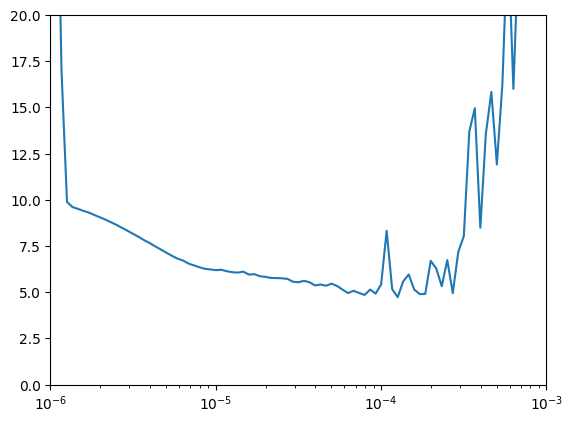

In [8]:
plt.semilogx(lr_opt_model.history["learning_rate"], lr_opt_model.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

#### Linear model with optimized learning rate

Now we use the learning rate, which we determined above.

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
   keras.layers.Input(shape=[window_size]),
  keras.layers.Dense(1), # input_shape=[window_size])
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 60.8614 - mae: 61.3596 - val_loss: 24.6506 - val_mae: 25.1489
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 10.9137 - mae: 11.4048 - val_loss: 8.3631 - val_mae: 8.8520
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9028 - mae: 8.3889 - val_loss: 8.7996 - val_mae: 9.2905
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7147 - mae: 8.1998 - val_loss: 8.1771 - val_mae: 8.6668
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7065 - mae: 8.1959 - val_loss: 8.1378 - val_mae: 8.6257
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7735 - mae: 8.2598 - val_loss: 8.0739 - val_mae: 8.5576
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4631 - mae: 7.9488 - val_loss: 8.2166 - val_mae: 8.7034
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7897 - mae: 8.2707 - val_loss: 8.2999 - val_mae: 8.7865
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

#### Forecast

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
# forecast based on linear deep learning model
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


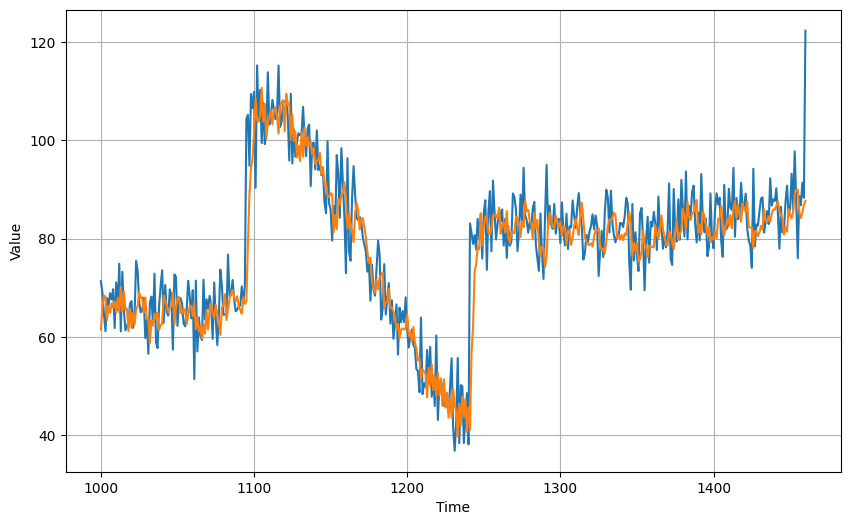

In [12]:


plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

4.993668

### Dense Model Forecasting

In [14]:
# use the following model first - try to improve


# this model consists of 3 layer with 10 or 1 units and a nonlinear activation function called "relu"
model = keras.models.Sequential([
  keras.layers.Input(shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])



In [15]:
# get inspired from the linear model

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)


# learning rate scheduler runs over a range of learning rates
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


# add callback with the learning rate scheduler
lr_opt_model = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 39.8750 - mae: 40.3739 - learning_rate: 1.0000e-06
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.9151 - mae: 37.4131 - learning_rate: 1.0798e-06
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.3757 - mae: 33.8750 - learning_rate: 1.1659e-06
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.7512 - mae: 29.2489 - learning_rate: 1.2589e-06
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.5333 - mae: 24.0309 - learning_rate: 1.3594e-06
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1951 - mae: 17.6897 - learning_rate: 1.4678e-06
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.4975 - mae: 11.9854 - learning_rate: 1.5849e-06
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.9253 - mae: 11.4152 - learning_rate: 1.7113e-06
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.2022 - mae: 10.6945 - learning_rate: 1.8478e-06
Epoch 10/1

(1e-06, 0.001, 0.0, 20.0)

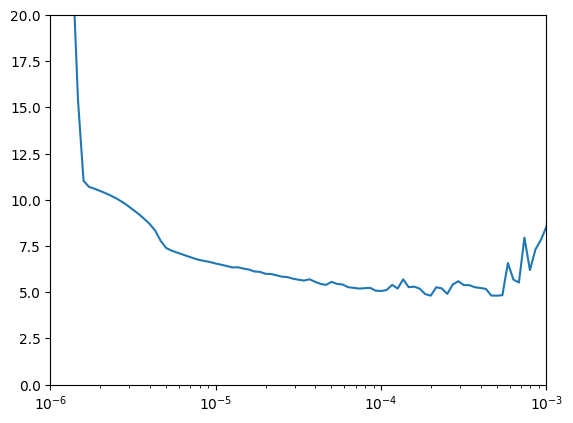

In [16]:
plt.semilogx(lr_opt_model.history["learning_rate"], lr_opt_model.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Input(shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

# learning rate scheduler runs over a range of learning rates
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


# add callback with the learning rate scheduler
lr_opt_model = model.fit(train_set, epochs=500, callbacks=[lr_schedule])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 45.3422 - mae: 45.8412 - learning_rate: 1.0000e-06
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.1507 - mae: 44.6505 - learning_rate: 1.0798e-06
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.1882 - mae: 43.6875 - learning_rate: 1.1659e-06
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.3810 - mae: 41.8800 - learning_rate: 1.2589e-06
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.3812 - mae: 40.8810 - learning_rate: 1.3594e-06
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.8989 - mae: 39.3978 - learning_rate: 1.4678e-06
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.6400 - mae: 38.1396 - learning_rate: 1.5849e-06
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.5917 - mae: 36.0910 - learning_rate: 1.7113e-06
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.2622 - mae: 30.7607 - learning_rate: 1.8478e-06
Epoch 10/5

In [ ]:
# forecast based on linear deep learning model
dense_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [ ]:

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Source: https://github.com/tensorflow/examples